In [4]:
# Cell 0: configuration & (optional) pip installs if missing
import sys, os

REVIEW_PATH = r"C:\Users\navee\Downloads\All_Beauty.jsonl\All_Beauty.jsonl"
META_PATH   = r"C:\Users\navee\Downloads\meta_All_Beauty.jsonl\meta_All_Beauty.jsonl"

print("Review exists:", os.path.exists(REVIEW_PATH))
print("Meta exists:", os.path.exists(META_PATH))

# Optional: install packages if not present (uncomment to use)
# NOTE: installs may require long time and kernel restart for tensorflow/prophet.
install_cmds = [
    # 'pip install prophet',            # Prophet package (if using PyPI 'prophet')
    # 'pip install xgboost',
    # 'pip install tensorflow',         # heavy
    # 'pip install orjson',             # faster JSON parsing
    # 'pip install statsmodels',
    # 'pip install pandas matplotlib seaborn nltk scikit-learn'
]
# If you want automatic install uncomment below:
# for cmd in install_cmds:
#     print("Running:", cmd)
#     os.system(f"{sys.executable} -m {cmd}")


Review exists: True
Meta exists: True


In [5]:
# Cell 1: parse JSONL, compute daily count, daily avg sentiment and rating (memory-friendly)
import json, time
from collections import Counter
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon', quiet=True)
sia = SentimentIntensityAnalyzer()

# Paths (use above variables)
REVIEW_PATH = REVIEW_PATH

# FAST parse: only extract keys we need (timestamp, text, rating)
start = time.time()
cnt = Counter()
sum_sent = {}
sum_rating = {}
cnt_rating = {}

lines = 0
malformed = 0
use_orjson = False
try:
    import orjson
    loads = orjson.loads
    use_orjson = True
except Exception:
    loads = json.loads

open_mode = 'rb' if use_orjson else 'r'
enc = None if use_orjson else 'utf-8'
with open(REVIEW_PATH, open_mode, encoding=enc) as fh:
    for raw in fh:
        lines += 1
        try:
            obj = loads(raw)
        except Exception:
            malformed += 1
            continue

        # timestamp detection (common keys)
        ts = obj.get('timestamp') or obj.get('time') or obj.get('unixReviewTime') or obj.get('review_time') or obj.get('date')
        if ts is None:
            continue
        try:
            ts = int(ts)
        except Exception:
            continue

        # convert to ms if needed
        ts_ms = ts if ts > 1_000_000_000_000 else ts * 1000
        day = pd.to_datetime(ts_ms, unit='ms', errors='coerce')
        if pd.isna(day):
            continue
        day = day.normalize()

        # update counts
        cnt[day] += 1

        # get text and rating for daily aggregate
        text = obj.get('text') or obj.get('reviewText') or obj.get('review_body') or obj.get('summary') or ""
        rating = obj.get('rating') or obj.get('overall') or obj.get('stars') or None
        # sentiment compute (fast)
        try:
            comp = sia.polarity_scores(str(text))['compound'] if text else 0.0
        except Exception:
            comp = 0.0

        # accumulate sentiment (convert compound [-1,1] to 0-5 later)
        sum_sent.setdefault(day, 0.0)
        sum_sent[day] += comp
        sum_rating.setdefault(day, 0.0)
        cnt_rating.setdefault(day, 0)
        if rating is not None:
            try:
                r = float(rating)
                sum_rating[day] += r
                cnt_rating[day] += 1
            except Exception:
                pass

        if lines % 200000 == 0:
            print(f"Processed {lines:,} lines — unique days: {len(cnt):,} — malformed: {malformed:,}")

end = time.time()
print(f"Parsing done. Lines: {lines:,}, malformed: {malformed:,}, elapsed: {end-start:.1f}s")

# Build DataFrame from counters
days = sorted(cnt.keys())
df = pd.DataFrame(index=days)
df['count'] = [cnt[d] for d in days]
# average compound -> convert to 0-5 scale: (compound+1)/2*5
df['avg_compound'] = [ (sum_sent.get(d,0.0) / cnt.get(d,1)) for d in days ]
df['sentiment'] = (df['avg_compound'] + 1.0) / 2.0 * 5.0
df['avg_rating'] = [ (sum_rating.get(d,0.0) / cnt_rating.get(d,1)) if cnt_rating.get(d,0)>0 else np.nan for d in days ]

# fill missing rating with forward-fill or global mean
df['rating'] = df['avg_rating'].fillna(method='ffill').fillna(df['avg_rating'].mean())

# ensure continuous daily index (fill missing days)
idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
daily_df = df.reindex(idx).fillna({'count':0})
# fill sentiment/rating for missing days sensibly
daily_df['sentiment'] = daily_df['sentiment'].fillna(method='ffill').fillna(daily_df['sentiment'].mean())
daily_df['rating']    = daily_df['rating'].fillna(method='ffill').fillna(daily_df['rating'].mean())

daily_df.index.name = 'ds'  # for prophet later
print("daily_df prepared:", daily_df.shape)
display(daily_df.head())
print("...")
display(daily_df.tail())


Processed 200,000 lines — unique days: 5,268 — malformed: 0
Processed 400,000 lines — unique days: 5,911 — malformed: 0
Processed 600,000 lines — unique days: 6,335 — malformed: 0
Parsing done. Lines: 701,528, malformed: 0, elapsed: 293.5s
daily_df prepared: (8018, 5)


,count,avg_compound,sentiment,avg_rating,rating
ds,,,,,
2001-09-27,1.0,0.8194,4.5485,5.0,5.0
2001-09-28,0.0,NaN,4.5485,NaN,5.0
2001-09-29,0.0,NaN,4.5485,NaN,5.0
2001-09-30,0.0,NaN,4.5485,NaN,5.0
2001-10-01,0.0,NaN,4.5485,NaN,5.0


...


,count,avg_compound,sentiment,avg_rating,rating
ds,,,,,
2023-09-05,0.0,NaN,3.890750,NaN,5.00
2023-09-06,1.0,0.621300,4.053250,5.00,5.00
2023-09-07,0.0,NaN,4.053250,NaN,5.00
2023-09-08,4.0,0.642075,4.105188,4.75,4.75
2023-09-09,1.0,-0.459200,1.352000,1.00,1.00


In [6]:
# Cell 2: train/test split + metrics
import numpy as np
import matplotlib.pyplot as plt

def safe_mape(actual, pred):
    actual = np.asarray(actual)
    pred = np.asarray(pred)
    mask = actual != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((actual[mask] - pred[mask]) / actual[mask])) * 100

def msle(actual, pred):
    actual = np.clip(np.asarray(actual), 0, None)
    pred = np.clip(np.asarray(pred), 0, None)
    return np.mean((np.log1p(pred) - np.log1p(actual))**2)

# Train/test split (80/20)
N = len(daily_df)
train_size = int(0.8 * N)
train_df = daily_df.iloc[:train_size].copy()
test_df  = daily_df.iloc[train_size:].copy()
print("Train days:", len(train_df), "Test days:", len(test_df))


Train days: 6414 Test days: 1604


Fitting SARIMAX... (this may take some seconds)
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 6414
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood              -24901.263
Date:                           Mon, 17 Nov 2025   AIC                          49816.527
Time:                                   21:41:22   BIC                          49863.880
Sample:                                        0   HQIC                         49832.917
                                          - 6414                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1424      1.081     -0.132      0.895      -2.261       1

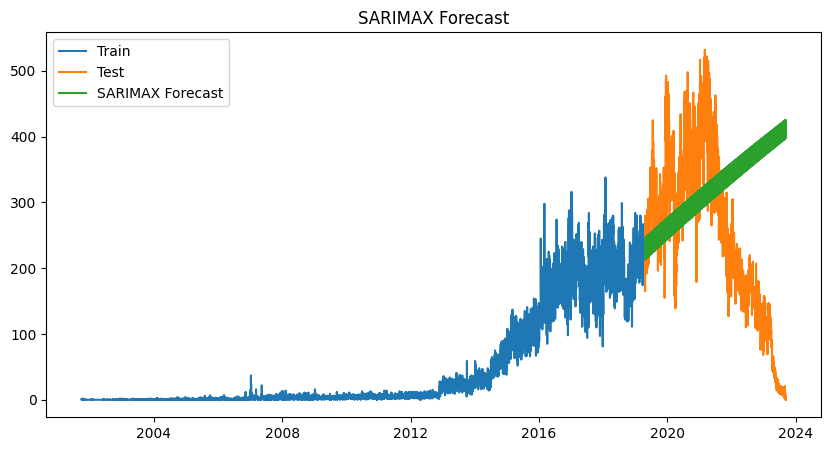

SARIMAX MAPE: 363.9086951198312
SARIMAX MSLE: 1.2562936416510808
SARIMAX 7-day forecast (values): [213.68903912 212.52991992 238.93324396 241.90934209 246.15558529
 238.87372073 231.82200523]


In [7]:
# Cell 3: SARIMAX with exogenous regressors
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt

y_train = train_df['count'].values
y_test  = test_df['count'].values
exog_train = train_df[['sentiment','rating']].values
exog_test  = test_df[['sentiment','rating']].values

# choose orders (tune later)
order = (1,1,1)
seasonal_order = (1,0,1,7)  # weekly seasonality

print("Fitting SARIMAX... (this may take some seconds)")
model = SARIMAX(endog=y_train, order=order, seasonal_order=seasonal_order, exog=exog_train,
                enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False, maxiter=50)
print(res.summary())

# Forecast for test period (same length)
n_forecast = len(test_df)
fc = res.get_forecast(steps=n_forecast, exog=exog_test)
fc_mean = np.asarray(fc.predicted_mean)
try:
    fc_ci = fc.conf_int(alpha=0.3).to_numpy()
except Exception:
    fc_ci = None

# Align and plot
idx = test_df.index[:len(fc_mean)]
plt.figure(figsize=(10,5))
plt.plot(train_df.index, train_df['count'], label='Train')
plt.plot(test_df.index, test_df['count'], label='Test')
plt.plot(idx, fc_mean, label='SARIMAX Forecast')
if fc_ci is not None and fc_ci.shape[0]==len(idx):
    plt.fill_between(idx, fc_ci[:,0], fc_ci[:,1], alpha=0.25)
plt.legend(); plt.title("SARIMAX Forecast"); plt.show()

# Metrics
min_len = min(len(y_test), len(fc_mean))
print("SARIMAX MAPE:", safe_mape(y_test[:min_len], fc_mean[:min_len]))
print("SARIMAX MSLE:", msle(y_test[:min_len], fc_mean[:min_len]))

# 7/10 day direct forecast using last available exog (repeat last day or use trend)
H = 7  # change to 10 for 10-day forecast
last_exog = exog_test[-1].reshape(1,-1)
exog_future = np.repeat(last_exog, H, axis=0)  # simple: repeat last values
fcH = res.get_forecast(steps=H, exog=exog_future)
fcH_mean = np.asarray(fcH.predicted_mean)
print(f"SARIMAX {H}-day forecast (values):", fcH_mean)


In [8]:
# Cell 4: Prophet model
# Install package if missing: pip install prophet
try:
    from prophet import Prophet
except Exception:
    try:
        from fbprophet import Prophet
    except Exception as e:
        raise ImportError("Prophet not installed. Install via 'pip install prophet' or 'pip install prophet==1.1' and restart kernel.") from e

# Prepare data for Prophet (ds,y)
prophet_df = daily_df.reset_index().rename(columns={'ds':'ds','count':'y'})[['ds','y']]
prop_train = prophet_df.iloc[:train_size].copy()
prop_test  = prophet_df.iloc[train_size:].copy()

m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
# Optionally add regressors
m.add_regressor('sentiment')
m.add_regressor('rating')

# fit requires regressors in df
prop_train_reg = prop_train.merge(daily_df.reset_index()[['ds','sentiment','rating']], on='ds', how='left')
m.fit(prop_train_reg)

# build future dataframe for test horizon + H days
n_forecast = len(prop_test)
future = prop_test[['ds']].copy().merge(daily_df.reset_index()[['ds','sentiment','rating']], on='ds', how='left')
forecast = m.predict(future)
# Align and evaluate on test
fc_prop = forecast.set_index('ds')['yhat'].reindex(prop_test['ds']).values
print("Prophet MAPE:", safe_mape(prop_test['y'].values, fc_prop))
print("Prophet MSLE:", msle(prop_test['y'].values, fc_prop))

# 7/10 day future example (use last known regressors repeated)
H = 7
last_row = daily_df.iloc[-1:].reset_index()
future_h = pd.DataFrame({'ds': pd.date_range(start=last_row['ds'].iloc[0] + pd.Timedelta(days=1), periods=H, freq='D')})
# use last known sentiment/rating repeated
future_h['sentiment'] = last_row['sentiment'].iloc[0]
future_h['rating']    = last_row['rating'].iloc[0]
fc_h = m.predict(future_h)
print(f"Prophet {H}-day forecast (yhat):\n", fc_h[['ds','yhat']])


21:42:38 - cmdstanpy - INFO - Chain [1] start processing
21:42:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAPE: 296.0512267153742
Prophet MSLE: 1.076158074011134
Prophet 7-day forecast (yhat):
           ds        yhat
0 2023-09-10  330.782860
1 2023-09-11  340.065859
2 2023-09-12  340.999371
3 2023-09-13  340.478186
4 2023-09-14  338.665570
5 2023-09-15  336.783995
6 2023-09-16  331.595895


In [9]:
# Cell 5: XGBoost approach (lag features + recursive forecasting)
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

df_feat = daily_df.copy()
# create calendar features
df_feat['dayofweek'] = df_feat.index.dayofweek
df_feat['month'] = df_feat.index.month

# create lag features (lags 1..14)
max_lag = 14
for lag in range(1, max_lag+1):
    df_feat[f'lag_{lag}'] = df_feat['count'].shift(lag)

# rolling stats
df_feat['rmean_7'] = df_feat['count'].rolling(7).mean().shift(1)
df_feat['rmean_14'] = df_feat['count'].rolling(14).mean().shift(1)

# drop initial rows with NaN
df_feat = df_feat.dropna().copy()

# split
train_feat = df_feat.iloc[:train_size].copy()
test_feat  = df_feat.iloc[train_size:].copy()

feature_cols = [c for c in df_feat.columns if c not in ('count', 'sentiment','rating','avg_compound')]
# but include sentiment and rating explicitly (they exist)
feature_cols = [c for c in feature_cols if c not in ('sentiment','rating')] + ['sentiment','rating']

X_train = train_feat[feature_cols].values
y_train = train_feat['count'].values
X_test  = test_feat[feature_cols].values
y_test  = test_feat['count'].values

# train XGBoost regressor
model_xgb = xgb.XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.05, verbosity=0)
model_xgb.fit(X_train, y_train)

# predict test
y_pred_xgb = model_xgb.predict(X_test)
print("XGBoost MAPE:", safe_mape(y_test, y_pred_xgb))
print("XGBoost MSLE:", msle(y_test, y_pred_xgb))

# Recursive H-day forecast using last available row
H = 7
last_row = df_feat.iloc[train_size-1:train_size].copy()  # last row before test
rec_preds = []
current_row = last_row.copy()
for h in range(H):
    # build feature vector
    fv = current_row[feature_cols].values[0].reshape(1,-1)
    p = model_xgb.predict(fv)[0]
    rec_preds.append(p)
    # shift window: create new row representing next day
    new_idx = current_row.index[0] + pd.Timedelta(days=1)
    new_row = current_row.copy()
    # update lags: shift previous lag values and insert predicted p at lag_1
    for lag in range(max_lag,1,-1):
        new_row[f'lag_{lag}'] = new_row[f'lag_{lag-1}']
    new_row['lag_1'] = p
    # update rolling means (approx): simple update
    # For exog, we repeat last sentiment/rating
    new_row['sentiment'] = new_row['sentiment'].iloc[0]
    new_row['rating'] = new_row['rating'].iloc[0]
    new_row['rmean_7'] = new_row['rmean_7'].iloc[0]  # keep same approx
    new_row['rmean_14'] = new_row['rmean_14'].iloc[0]
    new_row.index = [new_idx]
    current_row = new_row
rec_preds = np.array(rec_preds)
print(f"XGBoost recursive {H}-day forecast:", rec_preds)


XGBoost MAPE: 54.46249109012492
XGBoost MSLE: 0.21502021886267272
XGBoost recursive 7-day forecast: [55.877693 56.980446 54.4795   55.489906 55.893616 55.129074 54.101517]


In [10]:
# Cell 6: Multivariate LSTM (count, sentiment, rating) -> recursive multi-step forecast
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# prepare features
feat_cols = ['count','sentiment','rating']
features = daily_df[feat_cols].copy()

# scale using train only
scaler = MinMaxScaler()
scaler.fit(features.iloc[:train_size].values)
scaled = scaler.transform(features.values)

# create sequences
window = 14
def create_seq(data, window):
    X,y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i,0])  # predict count
    return np.array(X), np.array(y)

X, y = create_seq(scaled, window)
# align indexes for train/test
train_X = X[:train_size-window]
train_y = y[:train_size-window]
test_X  = X[train_size-window:]
test_y  = y[train_size-window:]

print("LSTM shapes:", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# build model
model = Sequential([
    LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2]), activation='tanh'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
print("Training LSTM (may take a while)...")
model.fit(train_X, train_y, epochs=30, batch_size=32, verbose=1)

# predict on test
y_pred_scaled = model.predict(test_X)
# invert scaling for target
dummy = np.zeros((y_pred_scaled.shape[0], features.shape[1]))
dummy[:,0] = y_pred_scaled.flatten()
y_pred = scaler.inverse_transform(dummy)[:,0]

# actual values (inverse scaled)
dummy_a = np.zeros((test_y.shape[0], features.shape[1]))
dummy_a[:,0] = test_y
y_actual = scaler.inverse_transform(dummy_a)[:,0]

print("LSTM MAPE:", safe_mape(y_actual, y_pred))
print("LSTM MSLE:", msle(y_actual, y_pred))

# recursive H-day forecast using last window
H = 7
last_window = scaled[-window:].copy()  # most recent window
rec_preds = []
cur_window = last_window.copy()
for h in range(H):
    x_in = cur_window.reshape(1, window, features.shape[1])
    p_scaled = model.predict(x_in)[0,0]
    # invert
    dummy_p = np.zeros((1, features.shape[1]))
    dummy_p[0,0] = p_scaled
    p = scaler.inverse_transform(dummy_p)[0,0]
    rec_preds.append(p)
    # update cur_window: drop first, append new row (we'll repeat last sentiment/rating)
    new_row = cur_window[-1].copy()
    new_row[0] = p_scaled  # predicted scaled count
    cur_window = np.vstack([cur_window[1:], new_row])
rec_preds = np.array(rec_preds)
print(f"LSTM recursive {H}-day forecast:", rec_preds)


LSTM shapes: (6400, 14, 3) (6400,) (1604, 14, 3) (1604,)
Training LSTM (may take a while)...
Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0036
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0021
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0021
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0019
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0019
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0019
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0019
Epoch 9/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018
Epoch 10/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018
Epoch 11/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018
Epoch 12/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017
Epoch 13/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016
Epoch 14/30
200/200 ━━━━━━━━━━━━

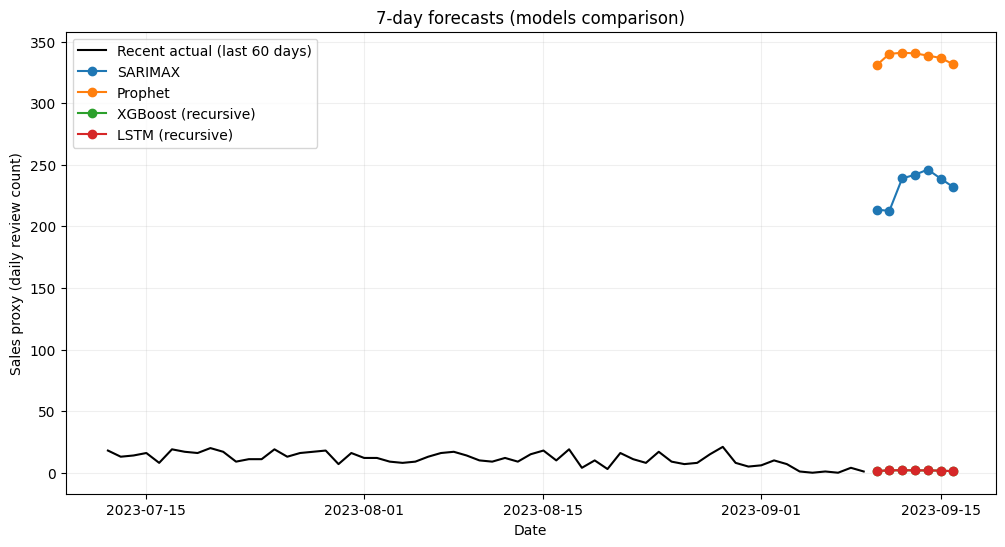

Found series:
 SARIMAX: True
 Prophet : True
 XGBoost : True
 LSTM    : True


In [14]:
# Cell 7 (fixed): collect 7-day forecasts from each model and plot safely
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

H = 7
last_date = daily_df.index.max()
future_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=H, freq='D')

def safe_extract_series(varname, idx=future_index, prefer_col=None):
    """Try to convert a global variable to a pd.Series aligned to idx."""
    if varname not in globals():
        return None
    v = globals()[varname]
    # Series -> return trimmed/extended to idx length
    if isinstance(v, pd.Series):
        arr = v.values
    # DataFrame -> try prefer_col then 'yhat' then first numeric column
    elif isinstance(v, pd.DataFrame):
        if prefer_col and prefer_col in v.columns:
            arr = v[prefer_col].values
        elif 'yhat' in v.columns:
            arr = v['yhat'].values
        else:
            # pick first numeric column
            numcols = v.select_dtypes(include=[np.number]).columns
            if len(numcols) == 0:
                return None
            arr = v[numcols[0]].values
    # numpy array or list
    elif isinstance(v, (np.ndarray, list, tuple)):
        arr = np.asarray(v).flatten()
    # pandas Index or ndarray-like
    else:
        try:
            arr = np.asarray(v).flatten()
        except Exception:
            return None

    # make sure arr length <= idx length, trim or pad if needed
    L = len(arr)
    if L == 0:
        return None
    if L > len(idx):
        arr = arr[:len(idx)]
        L = len(arr)
    # create index slice
    idx_use = idx[:L]
    return pd.Series(arr, index=idx_use)

# Candidate variable names that might hold forecasts (adapt if you renamed variables)
sarimax_candidates = ['fcH_mean', 'fcH', 'fcH_mean_array', 'fcH_mean']  # SARIMAX H-day
prophet_candidates  = ['fc_h', 'fc_h_df', 'fc_prophet', 'forecast']     # Prophet H-day (DataFrame with yhat)
xgb_candidates      = ['rec_preds_xgb', 'rec_preds_xg', 'rec_preds_xgb_array', 'rec_preds']
lstm_candidates     = ['rec_preds_lstm', 'rec_preds_lstm_array', 'rec_preds_lstm', 'rec_preds']

# extract first found for each model
s_sarimax = None
for c in sarimax_candidates:
    s_sarimax = safe_extract_series(c)
    if s_sarimax is not None:
        break

s_prophet = None
for c in prophet_candidates:
    s_prophet = safe_extract_series(c)
    if s_prophet is not None:
        break

s_xgb = None
for c in xgb_candidates:
    s_xgb = safe_extract_series(c)
    if s_xgb is not None:
        break

s_lstm = None
for c in lstm_candidates:
    s_lstm = safe_extract_series(c)
    if s_lstm is not None:
        break

# If Prophet variable exists as a DataFrame named 'fc_h' (common), handle separately:
if s_prophet is None and 'fc_h' in globals():
    v = globals()['fc_h']
    if isinstance(v, pd.DataFrame) and 'yhat' in v.columns:
        arr = v['yhat'].values.flatten()
        arr = arr[:len(future_index)] if len(arr) > len(future_index) else arr
        s_prophet = pd.Series(arr, index=future_index[:len(arr)])

# Plotting
plt.figure(figsize=(12,6))
plt.plot(daily_df.index[-60:], daily_df['count'].values[-60:], label='Recent actual (last 60 days)', color='black')

if s_sarimax is not None:
    plt.plot(s_sarimax.index, s_sarimax.values, marker='o', label='SARIMAX')
if s_prophet is not None:
    plt.plot(s_prophet.index, s_prophet.values, marker='o', label='Prophet')
if s_xgb is not None:
    plt.plot(s_xgb.index, s_xgb.values, marker='o', label='XGBoost (recursive)')
if s_lstm is not None:
    # if both XGB and LSTM used same name 'rec_preds', try to distinguish by length or warn
    plt.plot(s_lstm.index, s_lstm.values, marker='o', label='LSTM (recursive)')

plt.legend()
plt.title(f"{H}-day forecasts (models comparison)")
plt.xlabel("Date")
plt.ylabel("Sales proxy (daily review count)")
plt.grid(alpha=0.2)
plt.show()

# Print which series were found
print("Found series:")
print(" SARIMAX:", 'fcH_mean' in globals() or s_sarimax is not None)
print(" Prophet :", 'fc_h' in globals() or s_prophet is not None)
print(" XGBoost :", s_xgb is not None)
print(" LSTM    :", s_lstm is not None)

# If none of the model series were found, remind user which cells to run
if all(x is None for x in (s_sarimax, s_prophet, s_xgb, s_lstm)):
    print("\nNo forecast variables found. Make sure you ran the SARIMAX / Prophet / XGBoost / LSTM cells above.")
    print("Common variable names the plotting cell expects:")
    print(" - SARIMAX H-day array: fcH_mean")
    print(" - Prophet H-day DataFrame: fc_h (with column 'yhat') or forecast DataFrame")
    print(" - XGBoost recursive preds: rec_preds_xgb or rec_preds")
    print(" - LSTM recursive preds: rec_preds_lstm or rec_preds")


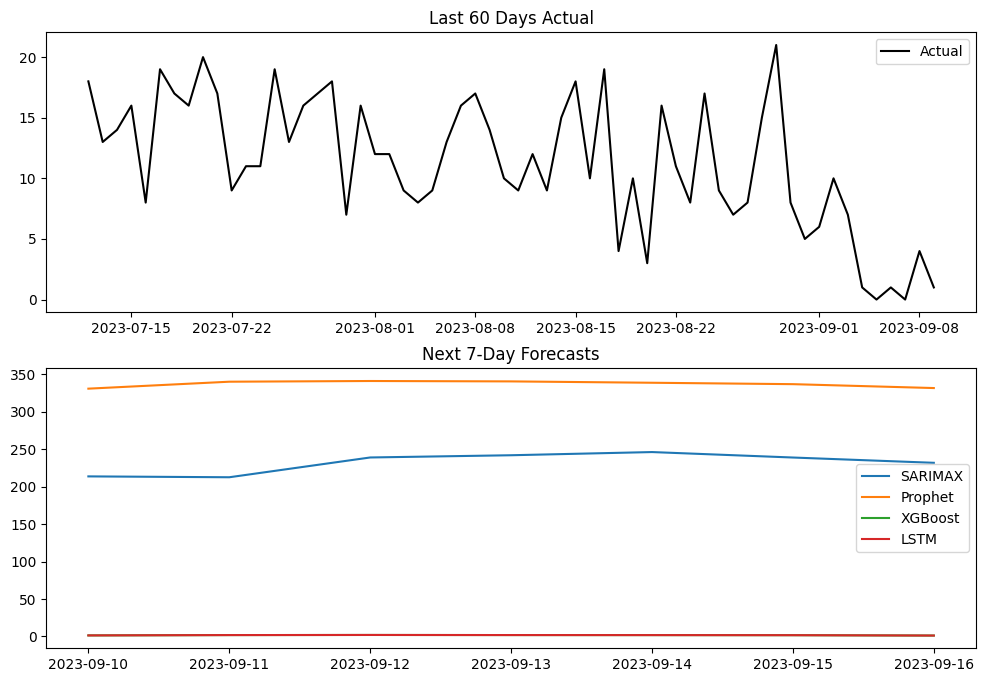

In [15]:
fig, axs = plt.subplots(2,1, figsize=(12,8), sharex=False)

# Actual last 60 days
axs[0].plot(daily_df.index[-60:], daily_df['count'].values[-60:], label='Actual', color='black')
axs[0].set_title("Last 60 Days Actual")
axs[0].legend()

# Predictions
if s_sarimax is not None: axs[1].plot(s_sarimax.index, s_sarimax.values, label="SARIMAX")
if s_prophet is not None: axs[1].plot(s_prophet.index, s_prophet.values, label="Prophet")
if s_xgb is not None: axs[1].plot(s_xgb.index, s_xgb.values, label="XGBoost")
if s_lstm is not None: axs[1].plot(s_lstm.index, s_lstm.values, label="LSTM")

axs[1].set_title("Next 7-Day Forecasts")
axs[1].legend()

plt.show()
